# Exploring the TED Talks Kaggle [dataset](https://www.kaggle.com/rounakbanik/ted-talks)

The purpose is to try and see what data could be useful for estimating `views` and/or `comments`.

In [1]:
# Import some libs and standard classes
from collections import defaultdict
import re

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 30)

In [2]:
# Implement some common util functions
flatten = lambda l: [item for sublist in l for item in sublist]

In [3]:
# Read and parse the data
df = pd.read_csv('data/ted_main.csv')
df['tags'] = df['tags'].apply(lambda tagsStr : tagsStr.replace("[", "").replace("]", "").replace("'", "").split(", "))
df['published_date_parsed'] = pd.to_datetime(df['published_date'], unit='s', utc=True)
df['published_date_parsed'] = df['published_date_parsed'].map(lambda timestamp: timestamp.date())
df['film_date_parsed'] = pd.to_datetime(df['film_date'], unit='s', utc=True)
df['film_date_parsed'] = df['film_date_parsed'].map(lambda timestamp: timestamp.date())

The `views` and `comments` by themselves do not constitute a sensible target value as they are heavily dependent on the age of the video (the time it was available online to be viewed and commented upon). We could of course directly target these and input the age of the video to our model, but it would unnecessarily complicated the task for it.   
Hence, we will normalize these 2 attributes by the time the video was available online. This is a rough estimation based on the date the dataset was last updated.

In [4]:
# Calculate several normalized attributes for views and comments
dataset_publish_time = 1506384000 # 09/26/2017 @ 00:00am (UTC), a rough estimation
hour_seconds = 3600
day_seconds = 24 * hour_seconds
week_seconds = 7 * day_seconds
df['views_per_hour_published'] = hour_seconds * df['views'] / (dataset_publish_time - df['published_date'])
df['comments_per_week_published'] = week_seconds * df['comments'] / (dataset_publish_time - df['published_date'])
df['comments_per_100k_views'] = 100000 * df['comments'] / df['views']

The per hour, week, 100k intervals were chosen after experimenting, so that the new attributes have nicer ranges.

In [5]:
#  Check the actual data
df.head(2)

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,published_date_parsed,film_date_parsed,views_per_hour_published,comments_per_week_published,comments_per_100k_views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"[children, creativity, culture, dance, educati...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,2006-06-27,2006-02-25,478.899953,7.756403,9.640649
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"[alternative energy, cars, climate change, cul...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,2006-06-27,2006-02-25,32.454429,0.451449,8.279905


In [6]:
# Check stats for the distribution of numeric attributes
df.describe()

,comments,duration,film_date,languages,num_speaker,published_date,views,views_per_hour_published,comments_per_week_published,comments_per_100k_views
count,2550.000000,2550.000000,2.550000e+03,2550.000000,2550.000000,2.550000e+03,2.550000e+03,2550.000000,2550.000000,2550.000000
mean,191.562353,826.510196,1.321928e+09,27.326275,1.028235,1.343525e+09,1.698297e+06,101.479333,1.065033,14.760930
std,282.315223,374.009138,1.197391e+08,9.563452,0.207705,9.464009e+07,2.498479e+06,276.368597,1.928086,16.071184
min,2.000000,135.000000,7.464960e+07,0.000000,1.000000,1.151367e+09,5.044300e+04,0.747603,0.018083,0.309514
25%,63.000000,577.000000,1.257466e+09,23.000000,1.000000,1.268463e+09,7.557928e+05,13.381237,0.307433,5.471637
50%,118.000000,848.000000,1.333238e+09,28.000000,1.000000,1.340935e+09,1.124524e+06,31.891948,0.598545,10.319986
75%,221.750000,1046.750000,1.412964e+09,33.000000,1.000000,1.423432e+09,1.700760e+06,83.281363,1.110579,17.741076
max,6404.000000,5256.000000,1.503792e+09,72.000000,5.000000,1.506092e+09,4.722711e+07,4836.426617,53.766273,221.960020


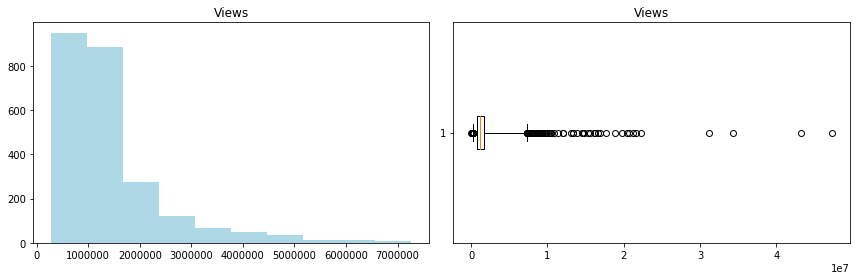

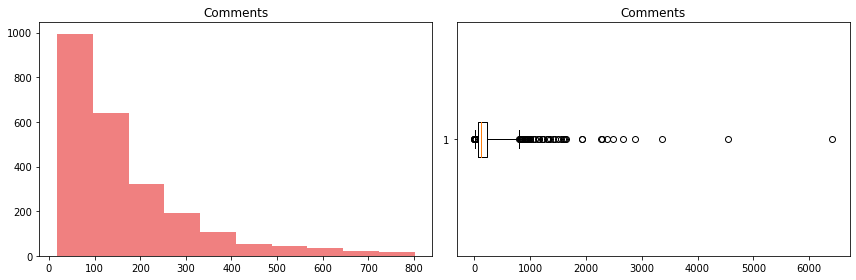

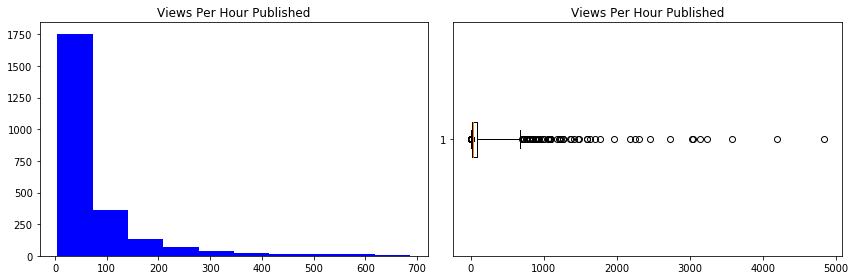

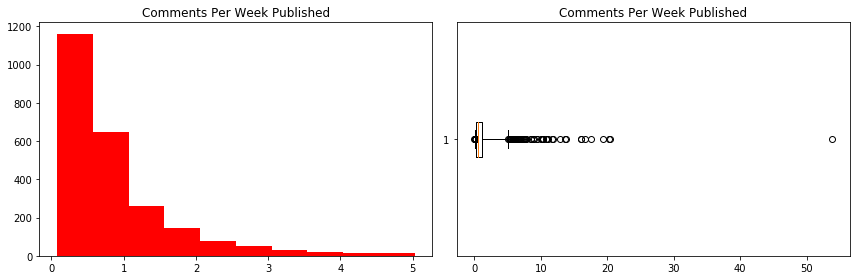

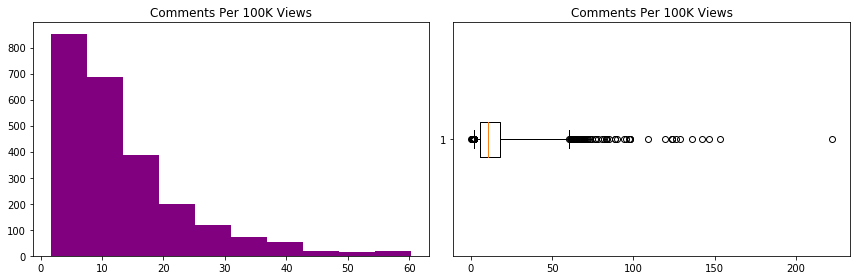

In [7]:
# Plot histograms and boxplots for views, comments and their normalized versions
hist_attributes = ['views', 'comments', 'views_per_hour_published', 'comments_per_week_published', 'comments_per_100k_views']
colors = { 'views': 'lightblue', 'comments': 'lightcoral', 'views_per_hour_published': 'blue', 'comments_per_week_published': 'red', 'comments_per_100k_views': 'purple' }

outliers_quantile = 0.025
min_ranges = { attr: df[attr].quantile(outliers_quantile) for attr in hist_attributes }
max_ranges = { attr: df[attr].quantile(1 - outliers_quantile) for attr in hist_attributes }

for attr in hist_attributes:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(df[attr], range=(min_ranges[attr], max_ranges[attr]), bins=10, facecolor=colors[attr])
    plt.title(attr.replace("_", " ").title())
  
    plt.subplot(1, 2, 2)
    plt.boxplot(df[attr], whis=[100 * outliers_quantile, 100 * (1 - outliers_quantile)], vert=False)
    plt.title(attr.replace("_", " ").title())
    
    plt.tight_layout()
    plt.show()

It is not a surprise that these attrbiutes follow the [power law](https://en.wikipedia.org/wiki/Power_law), most rankings do.    
The graphs from above do ignore `outliers_quantile` from each side (currently 2.5%).
### Let's see what different pairs of attributes can tell us

In [8]:
# Number of talks by UTC date of published_date
talks_by_published_date = df.groupby('published_date_parsed').apply(len).sort_values(ascending=False)
talks_by_published_date.head(10)

published_date_parsed
2007-04-05    20
2008-10-31     7
2006-06-27     6
2013-05-08     5
2007-04-06     5
2007-04-16     4
2007-07-31     3
2006-10-31     3
2010-01-08     3
2009-04-22     3
dtype: int64

In [9]:
# Number of talks by UTC date of film_date
talks_by_film_date = df.groupby('film_date_parsed').apply(len).sort_values(ascending=False)
talks_by_film_date.head(10)

film_date_parsed
2017-04-24    64
2007-03-03    54
2009-02-06    32
2009-02-05    30
2011-03-02    30
2008-02-02    29
2013-02-28    28
2016-02-15    28
2012-06-26    27
2011-07-13    27
dtype: int64

In [10]:
# Number of talks by event
talks_by_event = df.groupby('event').apply(len).sort_values(ascending=False)
talks_by_event.head(10)

event
TED2014           84
TED2009           83
TED2013           77
TED2016           77
TED2015           75
TED2011           70
TEDGlobal 2012    70
TED2010           68
TED2007           68
TEDGlobal 2011    68
dtype: int64

In [11]:
mean_views_php_by_published_date = df.pivot_table('views_per_hour_published', 'published_date_parsed', aggfunc='mean')
mean_views_php_by_published_date.sort_values('views_per_hour_published', ascending=False).head(10)

,views_per_hour_published
published_date_parsed,
2017-09-22,4836.426617
2017-09-21,3886.034542
2017-09-20,3237.156526
2017-09-18,3025.816540
2017-09-19,2890.010291
2017-09-12,2553.688016
2017-09-14,2349.063881
2017-09-06,2300.648421
2017-09-15,2178.258234


Something may be fishy with the data about those most recent talks. They seem to be gathering a lot more views on average.

In [12]:
mean_views_php_by_event = df.pivot_table(['views_per_hour_published'], ['event'], aggfunc='mean')
mean_views_php_by_event.sort_values('views_per_hour_published', ascending=False).head(10)

,views_per_hour_published
event,
TEDGlobal 2017,2203.823751
TEDxZurich,1966.641964
TEDxMileHigh,1812.722857
TEDxManchester,1307.512711
TEDxCrenshaw,1093.530512
TED2017,995.486325
TEDxHamburg,892.739549
TEDxSkoll,871.765344
TEDxPennsylvaniaAvenue,796.266050


 Or maybe there was indeed bigger audience at TEDGlobal 2017 which was watching the streams.

In [13]:
print("Correlations: ")
df.corr()

Correlations: 


,comments,duration,film_date,languages,num_speaker,published_date,views,views_per_hour_published,comments_per_week_published,comments_per_100k_views
comments,1.000000,0.140694,-0.133303,0.318284,-0.035489,-0.185936,0.530939,-0.034791,0.343277,0.478633
duration,0.140694,1.000000,-0.242941,-0.295681,0.022257,-0.166324,0.048740,-0.019562,0.073818,0.116533
film_date,-0.133303,-0.242941,1.000000,-0.061957,0.040227,0.902565,0.006447,0.339194,0.285062,-0.217449
languages,0.318284,-0.295681,-0.061957,1.000000,-0.063100,-0.171836,0.377623,-0.266792,-0.109355,-0.107787
num_speaker,-0.035489,0.022257,0.040227,-0.063100,1.000000,0.049240,-0.026389,0.007288,0.010853,-0.021189
published_date,-0.185936,-0.166324,0.902565,-0.171836,0.049240,1.000000,-0.017920,0.398272,0.315747,-0.280663
views,0.530939,0.048740,0.006447,0.377623,-0.026389,-0.017920,1.000000,0.155587,0.207927,-0.147298
views_per_hour_published,-0.034791,-0.019562,0.339194,-0.266792,0.007288,0.398272,0.155587,1.000000,0.713430,-0.194598
comments_per_week_published,0.343277,0.073818,0.285062,-0.109355,0.010853,0.315747,0.207927,0.713430,1.000000,0.095678
comments_per_100k_views,0.478633,0.116533,-0.217449,-0.107787,-0.021189,-0.280663,-0.147298,-0.194598,0.095678,1.000000


Pairs of variables with some correlation:

- comments, views (and normalized versions) - obvious relationship - it is expected that talks with more views will have more comments and vice versa
- film_date, published_date - obvious


- comments, languages - talks accessible to broader audience (languages) can get more comments, but possbily the "languages" (number of transcripts) capture the age of the video, which naturally correlates to the number of comments
- views, languages - same as above (but for views)


- comments_per_week_published, published_date/film_date - probably guessing the rate at which comments come
- views_per_hour_published, published_date/film_date - same as above (but for views)
- comments_per_100k_views, published_date - the newer talks seem to attract less comments (normalized by the views), but this may be skewed by outliers (very new videos, still not enough views)


- views_per_hour_published, languages - interestingly, there may be less views (normalized by the time the video was available) for talks that have transcripts in many languages (and vice versa - videos with a lot of views tend not to have multiple transcripts)? the correlation is quite low though
- languages, duration - this seems natural - longer videos tend to have less transcripts (because it's a harder work to transcribe them)


No strong and interesting relationships where observed between the pairs of numeric attributes.

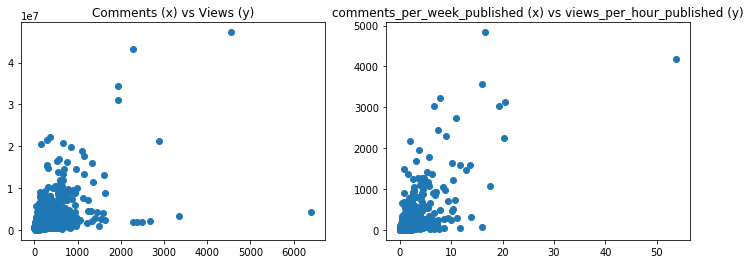

In [14]:
# Scatter plots of comments/views and their normalized variants
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Comments (x) vs Views (y)")
plt.scatter(df['comments'], df['views'])
plt.subplot(1, 2, 2)
plt.title("comments_per_week_published (x) vs views_per_hour_published (y)")
plt.scatter(df['comments_per_week_published'], df['views_per_hour_published'])
plt.show()

### Let's explore more of the non-numeric attributes now

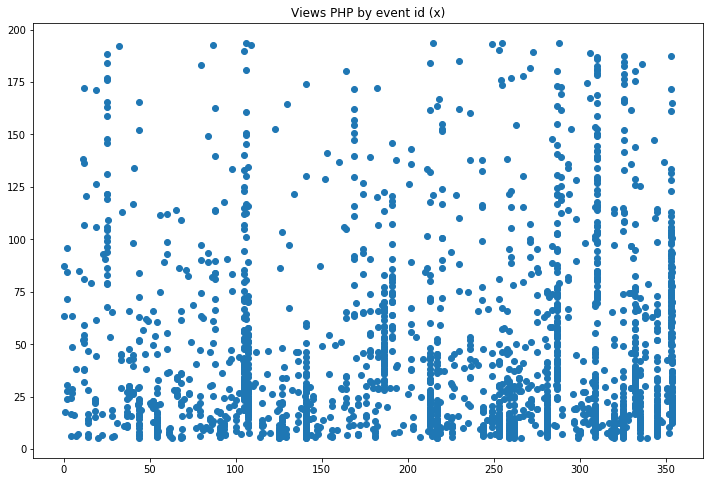

In [15]:
# Removing some outliers first
min_views_php = df['views_per_hour_published'].quantile(0.05)
max_views_php = df['views_per_hour_published'].quantile(0.9)

non_outlier_talks = df[(df['views_per_hour_published'] >= min_views_php) & (df['views_per_hour_published'] <= max_views_php)]
id_by_event = { event: index for index, event in enumerate(set(df['event'])) }

plt.figure(figsize=(12, 8))
plt.scatter(non_outlier_talks['event'].apply(lambda event: id_by_event[event]), non_outlier_talks['views_per_hour_published'])
plt.title("Views PHP by event id (x)")
plt.show()

In [16]:
# Sort events into several "types"
ted_type_regexes = {
    'ted_main': re.compile('^ted\s?\d{4}.*', flags=re.IGNORECASE),
    'ted_x': re.compile('^ted\s?x.*', flags=re.IGNORECASE),
    'ted_global': re.compile('^ted\s?global.*', flags=re.IGNORECASE),
    'ted_women': re.compile('^ted\s?women.*', flags=re.IGNORECASE),
    'ted_salon': re.compile('^ted\s?salon.*', flags=re.IGNORECASE),
    'ted_med': re.compile('^ted\s?med.*', flags=re.IGNORECASE),
    'ted_youth': re.compile('^ted\s?youth.*', flags=re.IGNORECASE),
}
ted_all_regex = re.compile('^ted.*', flags=re.IGNORECASE)

talks_by_event_type = {}
for ted_type, regex in ted_type_regexes.items():
    talks_by_event_type[ted_type] = df[df['event'].apply(lambda event : regex.match(event) is not None)]

other_ted_lambda = lambda event: ted_all_regex.match(event) is not None and all(ted_type_regexes[ted_type].match(event) is None for ted_type in ted_type_regexes)
talks_by_event_type['other_ted'] = df[df['event'].apply(other_ted_lambda)]
talks_by_event_type['not_ted'] = df[df['event'].apply(lambda event : ted_all_regex.match(event) is None)]

print("Events by type:\n")
for event_type, events in talks_by_event_type.items():
    print("{type}: {count}".format(type=event_type, count=events['event'].count()))
print("\nsum: ", sum([events['event'].count() for event_type, events in talks_by_event_type.items()]))
print("all: ", len(df['event']))

print("\nunique other events: ", len(set(talks_by_event_type['other_ted']['event'])))
# list(set(talks_by_event_type['other_ted']['event']))

Events by type:

ted_main: 978
ted_x: 471
ted_global: 463
ted_women: 96
ted_salon: 79
ted_med: 68
ted_youth: 19
other_ted: 265
not_ted: 111

sum:  2550
all:  2550

unique other events:  45


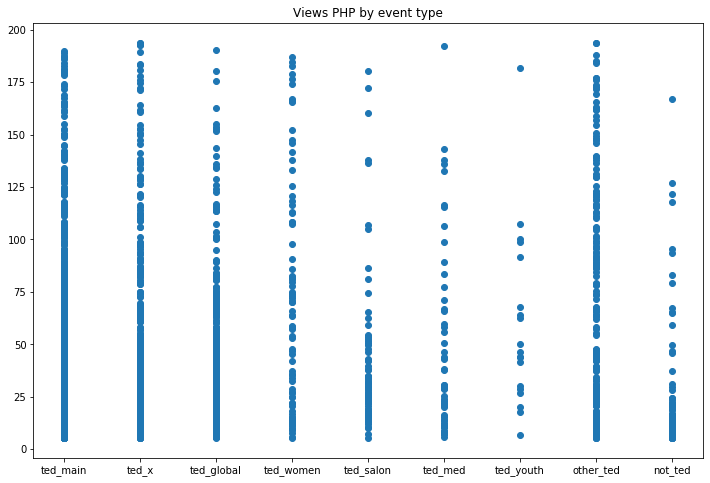

In [17]:
x = []
y = []

for event_type, talks in talks_by_event_type.items():
    non_outlier_talks = talks[(talks['views_per_hour_published'] >= min_views_php) & (talks['views_per_hour_published'] <= max_views_php)]
    x.extend([event_type] * len(non_outlier_talks))
    y.extend(non_outlier_talks['views_per_hour_published'])

plt.figure(figsize=(12, 8))
plt.scatter(x, y)
plt.title("Views PHP by event type")
plt.show()

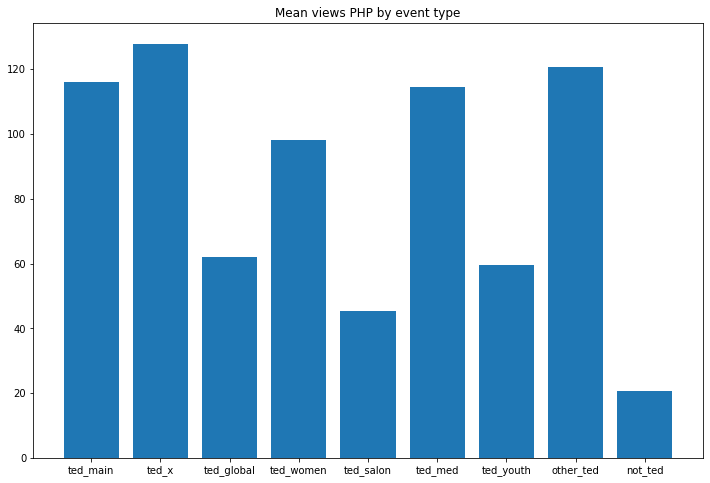

In [18]:
x = [event_type for event_type, talks in talks_by_event_type.items()]
y = [talks['views_per_hour_published'].mean() for event_type, talks in talks_by_event_type.items()]

plt.figure(figsize=(12, 8))
plt.bar(x, y)
plt.title("Mean views PHP by event type")
plt.show()

There might be something useful in the event type, or maybe we simply don't have enough data for some of the types.    
Turning our attention to `tags` now.

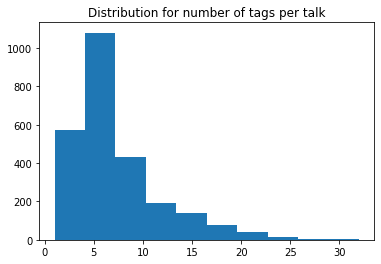

count    2550.000000
mean        7.511373
std         4.309849
min         1.000000
25%         5.000000
50%         6.000000
75%         9.000000
max        32.000000
Name: tags, dtype: float64

In [19]:
# Check the distribution for the number of tags added to a talk
plt.title("Distribution for number of tags per talk")
res = plt.hist(df['tags'].apply(len), bins=10)
plt.show()
df['tags'].apply(len).describe()

In [20]:
# Extract the unique tags and see how much they are
unique_tags = set(flatten(df['tags']))
print(len(unique_tags), "unique tags")

416 unique tags


In [21]:
# Make an index of talks by tag and get the top tags
talk_indices_by_tag = defaultdict(list)
for index, entry in df.iterrows():
    for tag in entry['tags']:
        talk_indices_by_tag[tag].append(index)

talk_data_by_tag = { tag : [len(talk_indices), df.iloc[talk_indices]['views_per_hour_published'].mean()] for tag, talk_indices in talk_indices_by_tag.items() }
tag_df = pd.DataFrame.from_dict(talk_data_by_tag, orient='index', columns=['talk_count', 'mean_views_php']).sort_values('mean_views_php', ascending=False)

# Remove outliers for the mean
tag_df[tag_df['talk_count'] >= tag_df['talk_count'].quantile(0.25)].head(20)

,talk_count,mean_views_php
public spaces,18,510.495537
friendship,11,492.697603
capitalism,13,488.549244
Mars,12,485.337218
Human body,10,462.994145
play,18,458.112723
United States,30,431.438517
immigration,14,403.101219
astrobiology,11,377.260415
personal growth,96,342.837092


Seems tags might also be useful in predicting views per hour published. 


We've seen that the `num_spekers` attrbiute does not correlate with the rest of the numeric ones, but let's delve some further into the `main_speaker` info.

In [22]:
df.groupby('main_speaker').apply(len).describe()

count    2156.000000
mean        1.182746
std         0.574799
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         9.000000
dtype: float64

Seems most speakers have exactly 1 talk, so this cannot help us much in estimating views/comments.

In [23]:
df.groupby('speaker_occupation').apply(len).describe()

count    1458.000000
mean        1.744856
std         2.995889
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        45.000000
dtype: float64

Same goes for `speaker_occupation` - the unique occupations are 1458 for a total of 2550 talks - on average there are only 1.744856 talks with the same `speaker_occupation` (heavily skewed to the right, as seen by the third quantile which still has a value of 1.0).

### Recap
We've normalized the views and comments by the time the video was available.
In following experiments we advise that `views_per_hours_published` should be used as the target variable.

We've observed how both views and comments (and their normalized versions) do follow the power law as expected.

We've seen that most of the numeric attributes do not directly correlate with the `views_per_hours_published` (outside the trivial comment-based atributes).   
The `published_date_parsed`, `tags` and "event type" were selected as potential source of knowledge, the last of which is a grouping of sorts of all the different `event` names into several bigger buckets like TedX, TedGlobal, etc.

Further insides for a model may be extracted based on some of the textual attributes - `title` and `description` (or even the full transcript). This is yet to be pursued.

The `ratings` were ignored in this exploration, as the expectation is that they are added after a talk is already viewed. They might however contain some useful data (e.g. people loved the talk, so we expect they'll spread the word and bring in more views).
Similarly, `related_talks` might contain useful information, but they fell out of scope for this analysis.